In [1]:
import torch
from torch.distributions import Normal
from utils.losses.elbo_linear_reg import elbo
from utils.fit import MeanFieldParams, FullRankParams, train_advi
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Set default type to float64 (instead of float32)
torch.set_default_dtype(torch.float64)

tensor([-8.3185,  6.5626, -0.1255,  8.9994,  4.3075,  6.9561, -8.1620,  0.6254,
        -4.4678, -6.0030])


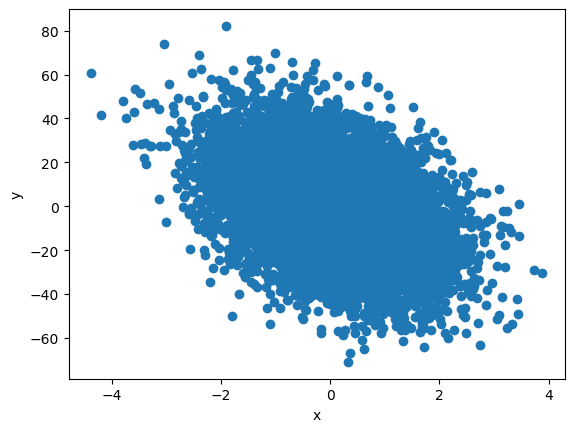

In [2]:
# Generate data
N = 11000
k = 10

# beta = np.array([0.1, -2.0])
sigma = 0.1
beta = Normal(0, 5).sample((k, ))
x = torch.randn(N, k) 
y = Normal(x@beta, sigma).rsample()

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=10000)

# Plot data
print(beta)
plt.scatter(x[:, 0].numpy(), y.numpy())
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [18]:
advi_mode = "fullrank"
advi_mode = "meanfield"

if advi_mode == "fullrank":
    model_params = {"params": FullRankParams(size=11)}
elif advi_mode == "meanfield":
    model_params = {'beta': MeanFieldParams(size=k), "sig": MeanFieldParams(1)}


elbo_hist = []
logpred_hist = []

In [24]:
elbo_hist, logpred_hist, _, _ = train_advi(
    x_train, y_train, x_val, y_val, 
    model_params, elbo,
    full_data_size=10000,
    max_iter=2000,
    batch_size=100,
    lr=0.001,
    advi_mode=advi_mode,
    elbo_hist=elbo_hist,
    logpred_hist=logpred_hist,
)

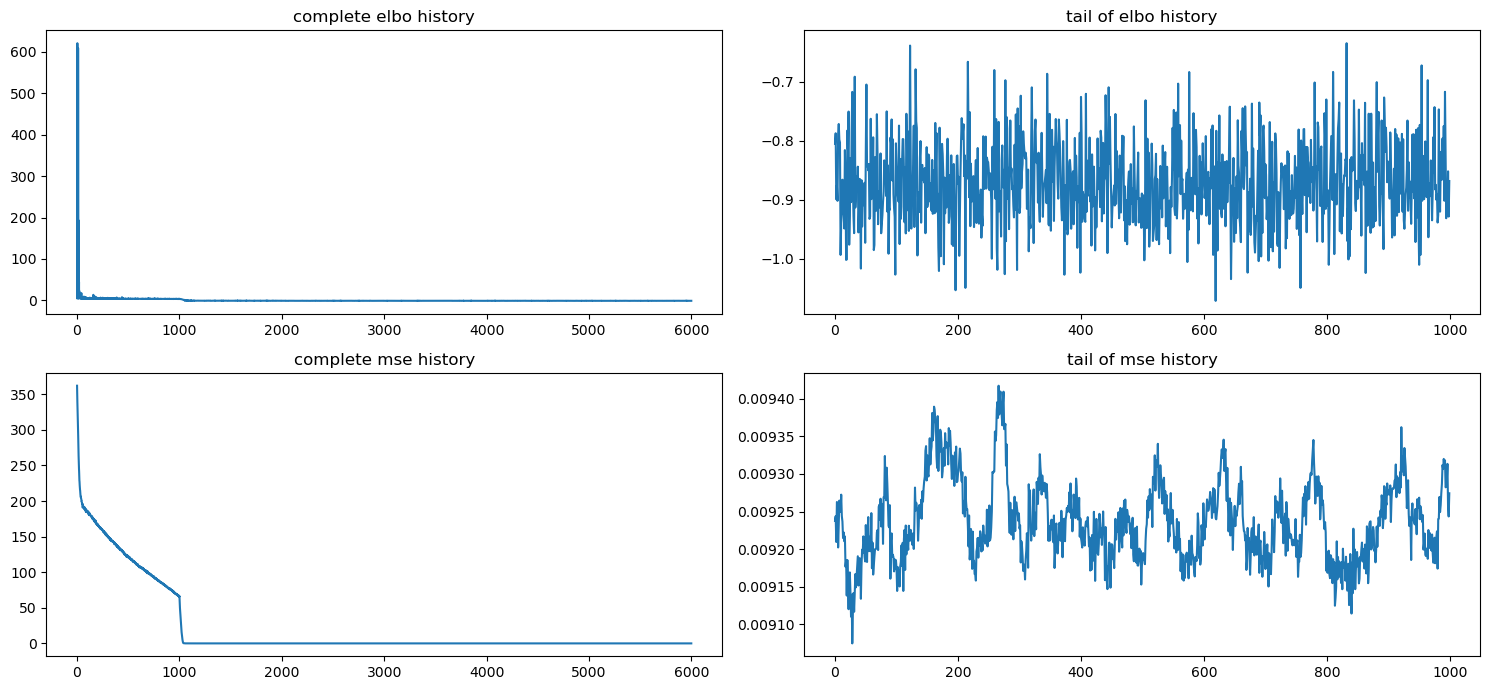

In [25]:
# Plot ELBO history
fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(15, 7))

axes[0, 0].plot(elbo_hist)
axes[0, 0].set_title('complete elbo history')

# Plot ELBO history (after 100-th iteration)
axes[0, 1].plot(elbo_hist[-1000:])
axes[0, 1].set_title('tail of elbo history')

# Plot ELBO history
axes[1, 0].plot(logpred_hist)
axes[1, 0].set_title('complete mse history')

# Plot ELBO history (after 100-th iteration)
axes[1, 1].plot(logpred_hist[-1000:])
axes[1, 1].set_title('tail of mse history')
plt.show()

In [ ]:
def transform(array):
    a = array[:10]
    b = array[10:]
    return np.concatenate([a, np.exp(b)])

In [26]:
# Inspect posterior
print('True beta: {}'.format(beta))
print('True sigma: {}'.format(sigma))
print()

if advi_mode == "fullrank":
    beta_mean = transform(model_params['params'].mean.detach().numpy())
    beta_mean = np.array_str(beta_mean, precision=4, suppress_small=True)
    print('param mean: {}'.format(beta_mean))
    beta_std = model_params['params'].L.detach().numpy()
    beta_std = np.array_str(beta_std@beta_std.T, precision=4, suppress_small=True)
    print('param sd: \n{}'.format(beta_std))
elif advi_mode == "meanfield":
    beta_mean = model_params['beta'].mean.detach().numpy()
    print('beta mean: {}'.format(beta_mean))
    beta_std = model_params['beta'].log_s.exp().detach().numpy()
    beta_std = np.array_str(beta_std, precision=4, suppress_small=True)
    print('beta sd: {}'.format(beta_std))
    sig_mean = model_params['sig'].mean.exp().detach().numpy()
    print('sig mean: {}'.format(sig_mean))
    sig_std = model_params['sig'].log_s.exp().detach().numpy()
    print('sig std: {}'.format(sig_std))

True beta: tensor([-8.3185,  6.5626, -0.1255,  8.9994,  4.3075,  6.9561, -8.1620,  0.6254,
        -4.4678, -6.0030])
True sigma: 0.1

beta mean: [-8.32328494  6.56427458 -0.12507039  8.99882003  4.31193074  6.95679472
 -8.16602575  0.62615445 -4.46956928 -6.00022609]
beta sd: [0.001  0.001  0.0011 0.0012 0.0012 0.0009 0.0014 0.0008 0.0011 0.0009]
sig mean: [0.10112802]
sig std: [0.00746899]
